In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random

## Phase 1: Discover Hot Points in Continuous Unknown Space
Assumptions:

    The space is 2D continuous: e.g., [0,100]×[0,100][0,100]×[0,100]

    There’s a fitness function that returns a value indicating how “hot” a point is. We'll simulate this with synthetic Gaussian peaks.

We’ll use Particle Swarm Optimization (PSO) to explore and detect local maxima.

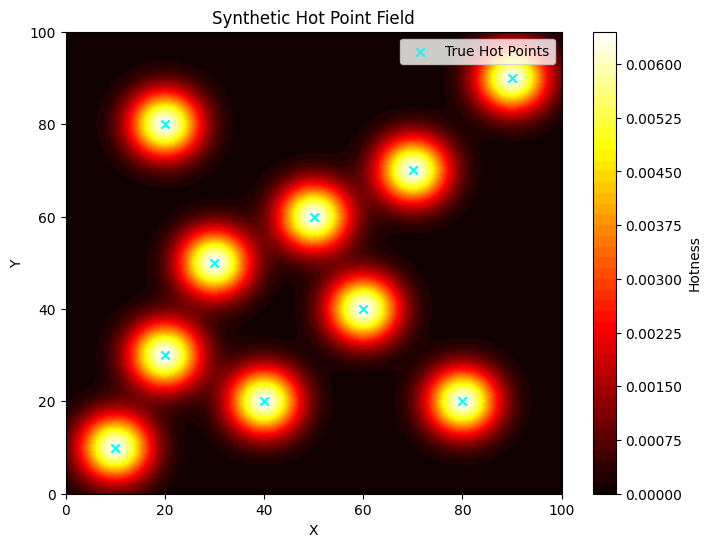

In [122]:
# Define synthetic hot spot function (sum of Gaussians)
def hot_point_field(xy, centers, covariances, weights):
    z = np.zeros(xy.shape[0])
    for center, cov, weight in zip(centers, covariances, weights):
        rv = multivariate_normal(mean=center, cov=cov)
        z += weight * rv.pdf(xy)
    return z

# Create a synthetic environment
np.random.seed(42)
centers = np.array([[20, 30], [50, 60], [80, 20], [20, 80], [70, 70], 
                    [90, 90], [30, 50], [60, 40], [40, 20], [10, 10]])
covariances = [np.diag([25, 25])] * 10
weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  # Equal weights for simplicity

# Evaluate on a grid for visualization
x = y = np.linspace(0, 100, 200)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])
Z = hot_point_field(points, centers, covariances, weights).reshape(200, 200)

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='hot')
plt.colorbar(label='Hotness')
plt.title("Synthetic Hot Point Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(*zip(*centers), c='cyan', marker='x', label='True Hot Points')
plt.legend()
plt.show()


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm b

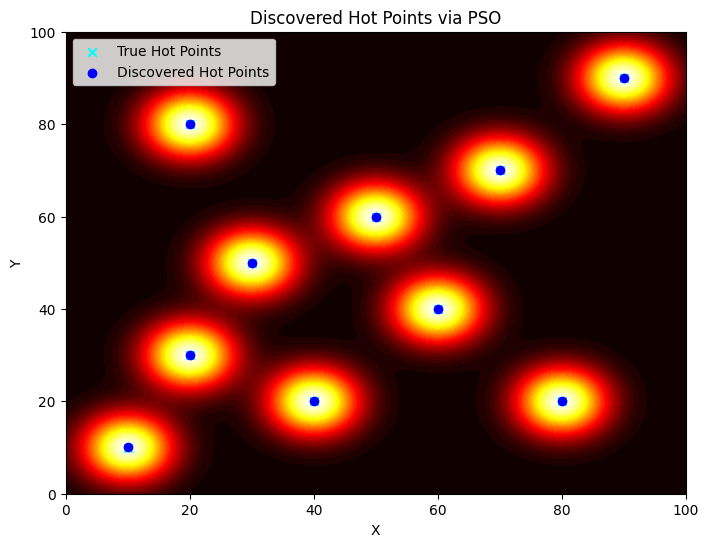

In [123]:
from pyswarm import pso  # install with: pip install pyswarm

# Define the objective function (negate because we want maxima)
def objective(p):
    p = np.array(p).reshape(-1, 2)
    return -hot_point_field(p, centers, covariances, weights)[0]

# Run PSO to find one peak
lb = [0, 0]
ub = [100, 100]
hot_points = []

for _ in range(100):  # Try to find 5 distinct hot points
    xopt, fopt = pso(objective, lb, ub, swarmsize=100, maxiter=100)
    if not any(np.linalg.norm(np.array(xopt) - np.array(p)) < 5 for p in hot_points):
        hot_points.append(xopt)

# Visualize discovered hot points
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='hot')
plt.scatter(*zip(*centers), c='cyan', marker='x', label='True Hot Points')
plt.scatter(*zip(*hot_points), c='blue', marker='o', label='Discovered Hot Points')
plt.legend()
plt.title("Discovered Hot Points via PSO")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Phase 2: Find Fastest Closed Path Using ACO
- Use the hot points discovered in Phase 1.
- Implement a basic ACO algorithm for TSP.
- Visualize the resulting shortest tour.

- Ants build tours probabilistically based on pheromone trails and distance heuristics.
- After each iteration, pheromones are updated to favor better paths.

In [124]:
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def total_distance(path, points):
    return sum(euclidean_distance(points[path[i]], points[path[(i + 1) % len(path)]]) for i in range(len(path)))


In [125]:
class AntColonyTSP:
    def __init__(self, points, n_ants=10, n_iterations=100, alpha=1.0, beta=5.0, rho=0.5, Q=100):
        self.points = points
        self.n = len(points)
        self.distances = np.array([[euclidean_distance(p1, p2) for p2 in points] for p1 in points])
        self.pheromone = np.ones((self.n, self.n))
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha  # influence of pheromone
        self.beta = beta    # influence of heuristic (1/distance)
        self.rho = rho      # pheromone evaporation
        self.Q = Q          # pheromone deposit factor

    def _choose_next(self, current, visited):
        pheromone = self.pheromone[current]
        heuristic = 1 / (self.distances[current] + 1e-10)
        prob = (pheromone ** self.alpha) * (heuristic ** self.beta)
        prob[list(visited)] = 0
        prob = prob / prob.sum()
        return np.random.choice(self.n, p=prob)

    def _build_path(self):
        path = [random.randint(0, self.n - 1)]
        visited = set(path)
        while len(path) < self.n:
            next_city = self._choose_next(path[-1], visited)
            path.append(next_city)
            visited.add(next_city)
        return path

    def optimize(self):
        best_path = None
        best_length = float('inf')

        for _ in range(self.n_iterations):
            all_paths = [self._build_path() for _ in range(self.n_ants)]
            all_lengths = [total_distance(path, self.points) for path in all_paths]

            # Update best
            for path, length in zip(all_paths, all_lengths):
                if length < best_length:
                    best_path = path
                    best_length = length

            # Evaporate
            self.pheromone *= (1 - self.rho)

            # Deposit
            for path, length in zip(all_paths, all_lengths):
                for i in range(len(path)):
                    a, b = path[i], path[(i + 1) % self.n]
                    self.pheromone[a][b] += self.Q / length
                    self.pheromone[b][a] += self.Q / length

        return best_path, best_length


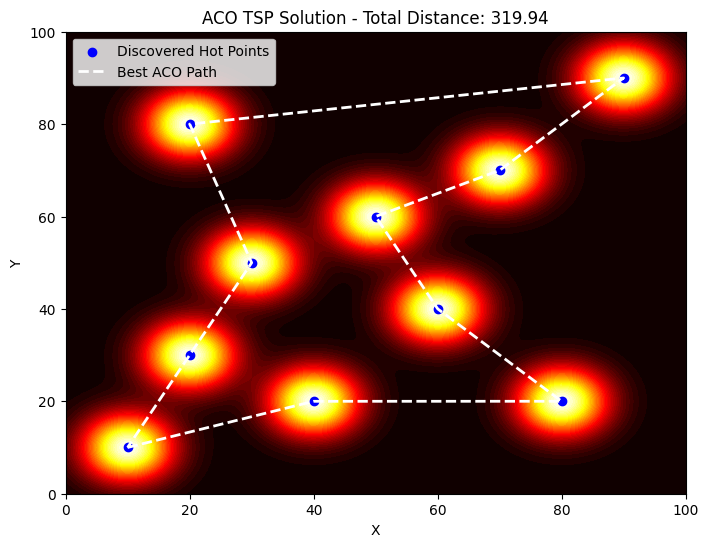

In [126]:
# Run ACO on hot points from Phase 1
aco = AntColonyTSP(hot_points, n_ants=20, n_iterations=200, alpha=1, beta=5, rho=0.5)
best_path, best_length = aco.optimize()

# Visualize the best path
ordered_points = [hot_points[i] for i in best_path] + [hot_points[best_path[0]]]  # Closed loop
x, y = zip(*ordered_points)

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='hot')
plt.scatter(*zip(*hot_points), c='blue', label='Discovered Hot Points')
plt.plot(x, y, 'w--', lw=2, label='Best ACO Path')
plt.title(f"ACO TSP Solution - Total Distance: {best_length:.2f}")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


## Phase 3: Dynamic Patrolling Strategy
Goal:
Ensure all hot points are revisited frequently, dynamically adjusting patrol behavior to:
- Minimize max time since last visit to any point
- React to point "importance" or event frequency
- Avoid simple looping when some points need more attention

### Strategy Overview
- Simulate a single patrolling agent moving along the ACO path.
- Track last visit time for each point.
- Dynamically adjust next target based on:
    - Time since last visit
    - Distance from current position
    - Optional: importance weight

In [127]:
def dynamic_patrol_score(current_pos, point, last_visited_time, current_time, importance=1.0):
    time_since_visit = current_time - last_visited_time
    distance = euclidean_distance(current_pos, point)
    
    # Score favors high time-since-visit and close points
    return (importance * time_since_visit) / (distance + 1)**0.5 #e-6

In [128]:
def simulate_dynamic_patrol(points, total_steps=300, speed=10.0):
    n_points = len(points)
    last_visit = np.zeros(n_points) + 0.1
    visits = [[] for _ in range(n_points)]
    current_time = 0
    current_pos = points[0]

    patrol_path = [current_pos]

    for t in range(total_steps):
        # Compute score for each point
        scores = [
            dynamic_patrol_score(current_pos, pt, last_visit[i], current_time)
            for i, pt in enumerate(points)
        ]
        # Choose best next point
        target_idx = np.argmax(scores)
        target = points[target_idx]

        # Move toward target by step size
        direction = np.array(target) - np.array(current_pos)
        distance = np.linalg.norm(direction)

        if distance <= speed:
            current_pos = target
            last_visit[target_idx] = current_time
            visits[target_idx].append(current_time)
        else:
            current_pos = current_pos + (direction / distance) * speed

        patrol_path.append(current_pos)
        current_time += 1

    return patrol_path, visits

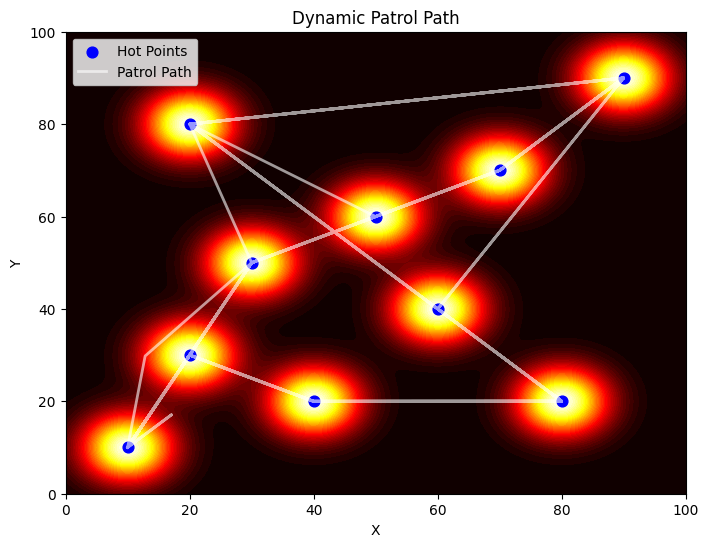

In [129]:
# Simulate patrol
path, visit_log = simulate_dynamic_patrol([hot_points[i] for i in best_path], total_steps=300)

# Visualize path
path = np.array(path)
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='hot')
plt.scatter(*zip(*hot_points), c='blue', s=60, label='Hot Points')
plt.plot(path[:, 0], path[:, 1], 'w-', alpha=0.6, lw=2, label='Patrol Path')
plt.title("Dynamic Patrol Path")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

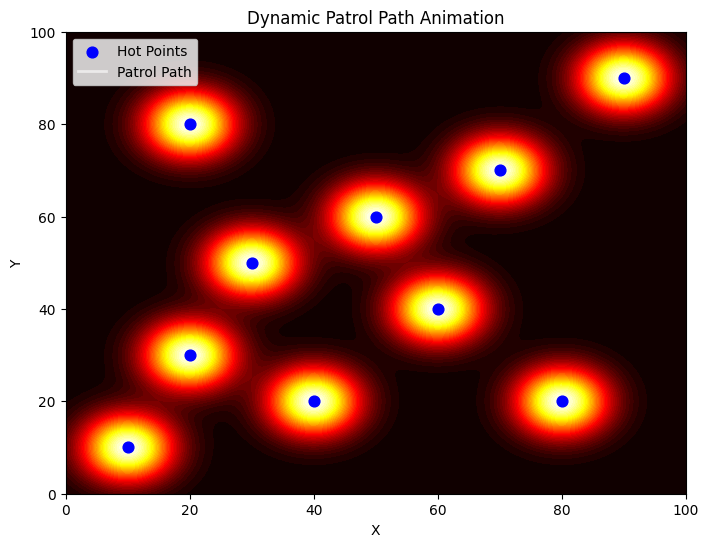

In [134]:
# visualize path with animation
import matplotlib.animation as animation
%matplotlib inline

def animate_patrol(path, interval=100):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(X, Y, Z, levels=50, cmap='hot')
    ax.scatter(*zip(*hot_points), c='blue', s=60, label='Hot Points')
    line, = ax.plot([], [], 'w-', alpha=0.6, lw=2, label='Patrol Path')
    ax.set_title("Dynamic Patrol Path Animation")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        #line.set_data(path[:frame+1, 0], path[:frame+1, 1])
        line.set_data(path[frame-1:frame+1, 0], path[frame-1:frame+1, 1])
        return line,

    ani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True, interval=interval)
    plt.show()
    return ani
ani = animate_patrol(path, interval=100)
# Save the animation as a video file
ani.save('dynamic_patrol.mp4', writer='ffmpeg', fps=15)

In [132]:
visit_log

[[1, 2, 3, 4, 39, 78, 120, 162, 204, 246, 288],
 [33, 72, 114, 156, 198, 240, 282],
 [28, 67, 109, 151, 193, 235, 277],
 [25, 64, 106, 148, 190, 232, 274],
 [13, 52, 86, 128, 170, 212, 254, 296],
 [16, 55, 89, 131, 173, 215, 257, 299],
 [19, 58, 92, 134, 176, 218, 260],
 [48, 100, 142, 184, 226, 268],
 [10, 44, 83, 125, 167, 209, 251, 293],
 [7, 36, 75, 117, 159, 201, 243, 285]]

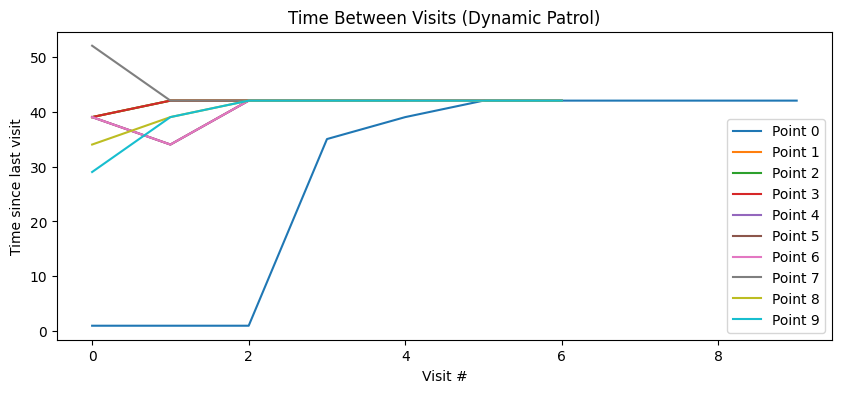

In [131]:
# Plot time between visits for each point
plt.figure(figsize=(10, 4))
for i, log in enumerate(visit_log):
    if len(log) > 1:
        times = np.diff(log)
        plt.plot(times, label=f'Point {i}')
plt.title("Time Between Visits (Dynamic Patrol)")
plt.xlabel("Visit #")
plt.ylabel("Time since last visit")
plt.legend()
plt.show()


In [ ]:
#####FROM HERE TO ADJUST

In [ ]:
def simulate_static_loop_patrol(points, total_steps=300, speed=1.5):
    n_points = len(points)
    last_visit = np.zeros(n_points)
    visits = [[] for _ in range(n_points)]
    current_time = 0
    current_pos = np.array(points[0])
    patrol_path = [current_pos.copy()]

    # Start looping over the ACO path
    current_target_idx = 1

    for t in range(total_steps):
        target = np.array(points[current_target_idx])
        direction = target - current_pos
        distance = np.linalg.norm(direction)

        if distance <= speed:
            current_pos = target
            last_visit[current_target_idx] = current_time
            visits[current_target_idx].append(current_time)

            # Move to the next target in loop
            current_target_idx = (current_target_idx + 1) % n_points
        else:
            # Move toward target
            current_pos = current_pos + (direction / distance) * speed

        patrol_path.append(current_pos.copy())
        current_time += 1

    return np.array(patrol_path), visits

In [ ]:
def analyze_visit_logs(visits):
    stats = []
    for i, log in enumerate(visits):
        if len(log) > 1:
            intervals = np.diff(log)
            max_interval = np.max(intervals)
            std_interval = np.std(intervals)
            stats.append((i, max_interval, std_interval))
    return stats

In [ ]:
# Run both patrol strategies
dynamic_path, dynamic_visits = simulate_dynamic_patrol([hot_points[i] for i in best_path], total_steps=300)
static_path, static_visits = simulate_static_loop_patrol([hot_points[i] for i in best_path], total_steps=300)

# Analyze both
dynamic_stats = analyze_visit_logs(dynamic_visits)
static_stats = analyze_visit_logs(static_visits)

# Print and compare
print("Point | Max Interval (Static) | Std Dev (Static) || Max Interval (Dynamic) | Std Dev (Dynamic)")
print("------|------------------------|------------------||------------------------|------------------")
for i in range(len(dynamic_stats)):
    s_max, s_std = static_stats[i][1], static_stats[i][2]
    d_max, d_std = dynamic_stats[i][1], dynamic_stats[i][2]
    print(f"{i:5} | {s_max:22.2f} | {s_std:16.2f} || {d_max:22.2f} | {d_std:16.2f}")

In [ ]:
def plot_visit_intervals(visits_a, visits_b, label_a="Static", label_b="Dynamic"):
    plt.figure(figsize=(12, 5))
    for i in range(len(visits_a)):
        if len(visits_a[i]) > 1 and len(visits_b[i]) > 1:
            intervals_a = np.diff(visits_a[i])
            intervals_b = np.diff(visits_b[i])
            plt.plot(intervals_a, label=f'{label_a} - Point {i}', linestyle='--')
            plt.plot(intervals_b, label=f'{label_b} - Point {i}', linestyle='-')
    plt.title("Time Between Visits")
    plt.xlabel("Visit #")
    plt.ylabel("Interval")
    plt.legend()
    plt.grid(True)
    plt.show()